# GP from scratch

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)
#

In [2]:
# Define the exponentiated quadratic
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [3]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [4]:
from astropy.time import Time
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from sklearn.gaussian_process import GaussianProcessRegressor
plt.style.use('default')

In [5]:
data_path = '../../Data/'
work_path = '.'

In [6]:
file1 = data_path + '0718alma.dat'
df = np.genfromtxt(file1)
bmjd = (df[:, 2] - df[:, 2][0]) / (df[:, 2][-1] - df[:, 2][0]) * 10 # scaling between 0 and 10
flux = df[:, 3]

Text(0, 0.5, '[Jy]')

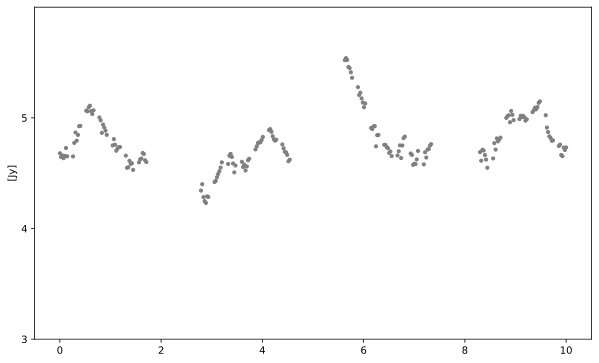

In [7]:
# Create a single figure with three subplots that share the same x-axis
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(bmjd, flux, s=10, color='tab:gray')
axs.set_ylim(3, 6)
axs.set_yticks([3.0, 4.0, 5.0])
axs.set_ylabel('[Jy]')

In [14]:
# Compute the posterior mean and covariance
n_test = 100
ny = 5 # number of functions to sample
X1 = bmjd.reshape(-1, 1)
y1 = flux
# X2 = date_range_timestamps.reshape(-1, 1)
X2 = np.linspace(bmjd[0], bmjd[-1], n_test).reshape(-1, 1)
n1 = len(y1)
np.random.seed(42)

σ_noise = .2  # The standard deviation of the noise

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

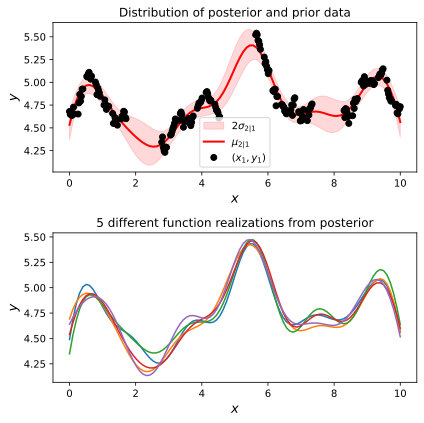

In [15]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
# ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red',
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
# ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
# ax1.axis([domain[0], domain[1], -3, 3])
# ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

# GP with GPy on Alma data

In [15]:
import GPy

In [16]:
def plot_GPy(model : GPy.core.gp.GP, obs_X, obs_y, color='#1f77b4', marker='x', markercolor='black'):
  X = np.linspace(0, 10, 10000).reshape(-1, 1)
  preds = model.predict(X)[0].flatten()
  lower, upper = model.predict_quantiles(X=X, quantiles=(16, 84))

  lower, upper = lower.flatten(), upper.flatten()
  X = X.flatten()

  plt.plot(X, preds)
  plt.plot(X, lower, alpha=0.2, color=color)
  plt.plot(X, upper, alpha=0.2, color=color)
  plt.scatter(obs_X.flatten(), obs_y, marker=marker, color=markercolor)
  plt.fill_between(X, lower, upper, alpha=0.2)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.020515e+02           nan 

    00s03  0004   2.112170e+02   3.440815e+05 
    00s09  0013  -2.082826e+02   4.317954e+02 
    00s12  0017  -2.195792e+02   8.443717e+02 
    00s16  0023  -2.279874e+02   1.980838e+01 
    00s22  0032  -2.280689e+02   2.144406e-09 
Runtime:     00s22
Optimization status: Converged



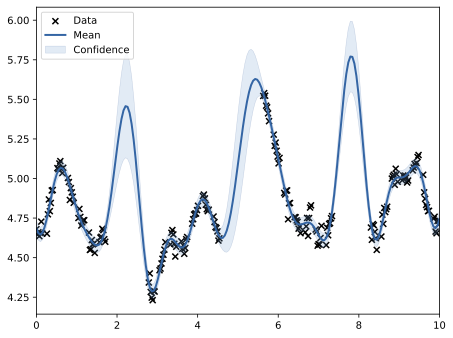

In [17]:
rbf_kern = GPy.kern.RBF(1)
gauss = GPy.likelihoods.Gaussian(variance=.2)
exact = GPy.inference.latent_function_inference.ExactGaussianInference()
m1 = GPy.core.GP(X=X1, Y=y1.reshape(-1, 1), kernel=rbf_kern, likelihood=gauss, inference_method=exact)
m1.optimize(messages=1)
_ = m1.plot(plot_limits=[0, 10], lower=16, upper=84)
m1

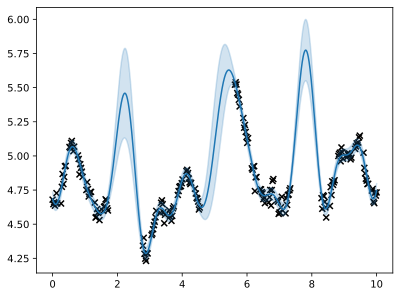

In [18]:
plot_GPy(m1, obs_X = X1, obs_y = y1)

# MOPG with GPy on all but Spitzer data

In [19]:
from astropy.time import Time
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
plt.style.use('default')

Amount of data samples in plot NuSTAR: 107
Amount of data samples in plot Chandra: 191
Amount of data samples in plot VLT: 39
Amount of data samples in plot Spitzer: 6856
Amount of data samples in plot ALMA: 196
Total amount of data samples: 7389


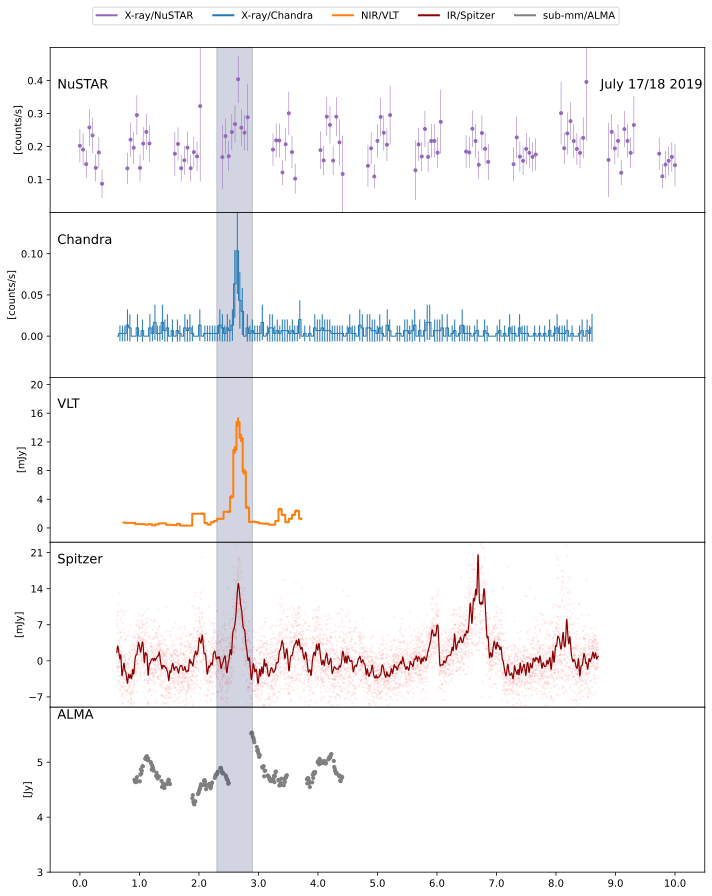

In [20]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1 - NuSTAR
axs[0].errorbar(scaled_bmjd1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].set_ylim(0, 0.5)
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[0].set_ylabel('[counts/s]')

# Plot 2 - Chandra
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
scaled_bmjd2 = rescale_bmjd(bmjd2, bmjd1)
flux2 = df2[:, 1]
error2 = df2[:, 2]
axs[1].errorbar(scaled_bmjd2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].set_ylim(-0.05, 0.15)
axs[1].set_yticks([0.0, 0.05, 0.10])
axs[1].set_ylabel('[counts/s]')

# Plot 3 - VLT
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
scaled_bmjd3 = rescale_bmjd(bmjd3, bmjd1)
flux3 = df3[:, 1]
error3 = df3[:, 2]
axs[2].errorbar(scaled_bmjd3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].set_ylim(-2, 21)
axs[2].set_yticks([0, 4, 8, 12, 16, 20])
axs[2].set_ylabel('[mJy]')

# Plot 4 - Spitzer
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
scaled_bmjd4 = rescale_bmjd(bmjd4, bmjd1)
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
axs[3].plot(scaled_bmjd4, flux_binned4, linewidth=1.2, color='darkred')
axs[3].scatter(scaled_bmjd4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-9, 23)
axs[3].set_yticks([-7, 0, 7, 14, 21])
axs[3].set_ylabel('[mJy]')

# Plot 5 - ALMA
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
scaled_bmjd5 = rescale_bmjd(bmjd5, bmjd1)
flux5 = df5[:, 3]
axs[4].scatter(scaled_bmjd5, flux5, s=10, color='tab:gray')
axs[4].set_ylim(3, 6)
axs[4].set_yticks([3.0, 4.0, 5.0])
axs[4].set_ylabel('[Jy]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[2].set_xticks(xticks)
axs[2].set_xticklabels(xtick_labels, rotation=45)
axs[2].set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
    Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
    Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
    Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
]

# Add annotations
fig.text(0.84, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'NuSTAR', fontsize=13)
fig.text(0.085, 0.76, 'Chandra', fontsize=13)
fig.text(0.085, 0.57, 'VLT', fontsize=13)
fig.text(0.085, 0.39, 'Spitzer', fontsize=13)
fig.text(0.085, 0.21, 'ALMA', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
for ax in axs:
    ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

print('Amount of data samples in plot NuSTAR: %d' % len(scaled_bmjd1))
print('Amount of data samples in plot Chandra: %d' % len(scaled_bmjd2))
print('Amount of data samples in plot VLT: %d' % len(scaled_bmjd3))
print('Amount of data samples in plot Spitzer: %d' % len(scaled_bmjd4))
print('Amount of data samples in plot ALMA: %d' % len(scaled_bmjd5))
print('Total amount of data samples: %d' % (len(scaled_bmjd1) + len(scaled_bmjd2) + len(scaled_bmjd3) + len(scaled_bmjd4) + len(scaled_bmjd5)))

# Show the combined figure
plt.show()

In [21]:
# Create a single input array for all datasets
X1 = scaled_bmjd1[:, None]  # NuSTAR
X2 = scaled_bmjd2[:, None]  # Chandra
X3 = scaled_bmjd3[:, None]  # VLT
X4 = scaled_bmjd4[:, None]  # Spitzer
X5 = scaled_bmjd5[:, None]  # ALMA

# Create a single output array for all datasets
Y1 = flux1[:, None]
Y2 = flux2[:, None]
Y3 = flux3[:, None]
Y4 = flux_binned4[:, None]
Y5 = flux5[:, None]

# Combine inputs and outputs
X = np.vstack((X1, X2, X3, X4, X5))
Y = np.vstack((Y1, Y2, Y3, Y4, Y5))

# Create an index array to indicate which output each point corresponds to
output_index = np.vstack((np.zeros_like(Y1), np.ones_like(Y2), 2*np.ones_like(Y3), 3*np.ones_like(Y4), 4*np.ones_like(Y5)))

In [22]:
model = GPy.models.GPCoregionalizedRegression(X_list = [X1, X2, X3, X5], Y_list = [Y1, Y2, Y3, Y5])
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0002   6.276997e+02   1.320920e+04 
    00s12  0003  -9.706715e+00   1.354516e+04 
    01s13  0020  -7.534974e+02   2.064554e+05 
    03s16  0057  -8.758029e+02   1.402124e+06 
    08s53  0142  -8.860773e+02   2.209938e+02 
    19s80  0403  -9.042839e+02   1.375379e+03 
    37s36  0832  -9.092418e+02   2.493114e+01 
    47s23  1002  -9.092778e+02   1.806629e+00 
Runtime:     47s23
Optimization status: Maximum number of f evaluations reached



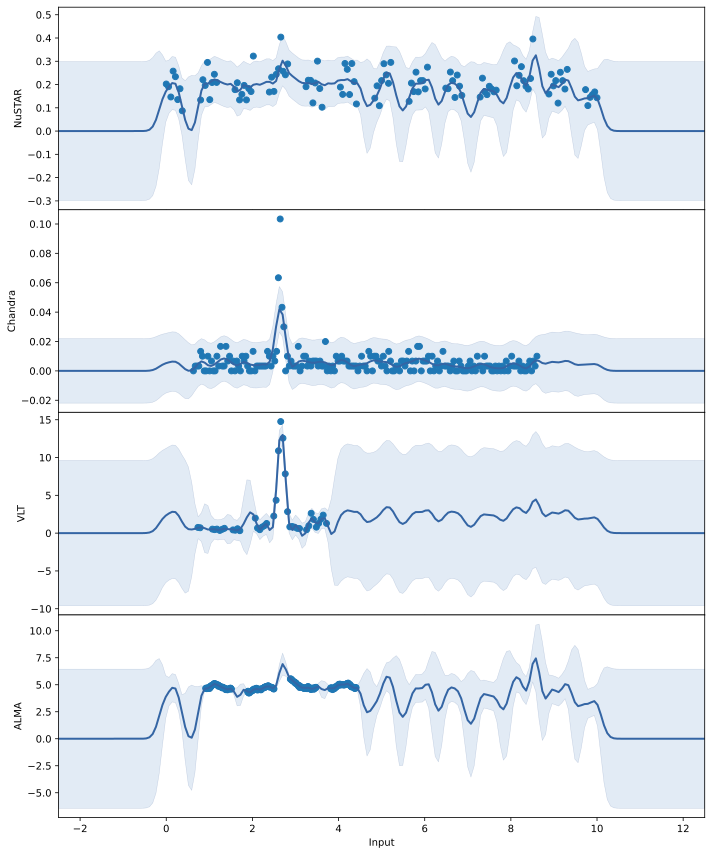

In [23]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True)
X_list = [X1, X2, X3, X5]
Y_list = [Y1, Y2, Y3, Y5]
y_labels = ['NuSTAR', 'Chandra', 'VLT', 'ALMA']

# Loop through each output and plot in its respective subplot
for i in range(4):
    model.plot(plot_data = False, fignum=None, fixed_inputs=[(1, i)], ax=axs[i], legend=False)
    axs[i].scatter(X_list[i], Y_list[i])
    # axs[i].set_title()
    axs[i].set_ylabel(y_labels[i])
    if i == 3:
        axs[i].set_xlabel('Input')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


(4.0, 6.25)

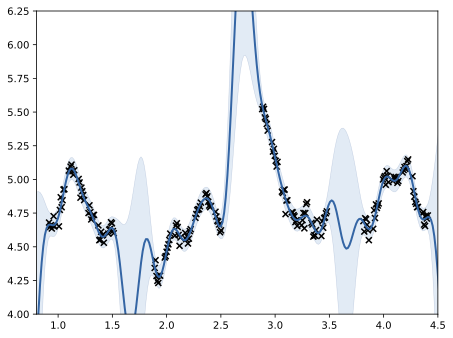

In [24]:
model.plot(plot_data = False, fignum=None, fixed_inputs=[(1, 3)], legend=False, resolution=1000)
plt.scatter(X_list[3], Y_list[3], marker='x', color='black')
plt.xlim(0.8, 4.5)
plt.ylim(4, 6.25)

# Interpolating unevenly sampled Spitzer data - Comparison of GP vs MOPG

Start by removing data from Spitzer

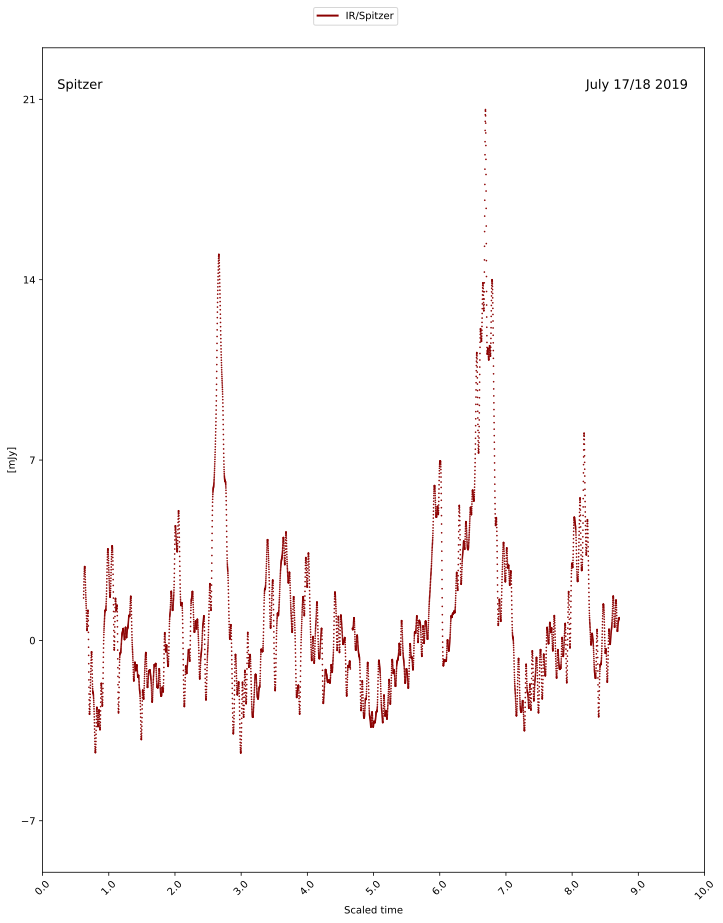

In [25]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)


# Plot 4 - Spitzer
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
scaled_bmjd4 = rescale_bmjd(bmjd4, bmjd1)
# flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
axs.scatter(scaled_bmjd4, flux_binned4, s=0.5, color='darkred')
# axs.scatter(scaled_bmjd4, flux_excess4, color='red', alpha=0.05, s=2)
axs.set_ylim(-9, 23)
axs.set_yticks([-7, 0, 7, 14, 21])
axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

In [104]:
fraction_to_keep = 0.01  # e.g., keep 10% of the data points
num_points_to_keep = int(fraction_to_keep * len(flux_binned4))
indices = np.random.choice(len(flux_binned4), size=num_points_to_keep, replace=False)

X_train = scaled_bmjd4[indices]
y_train = flux_binned4[indices]
X_test = np.delete(scaled_bmjd4, indices)
y_test = np.delete(flux_binned4, indices)

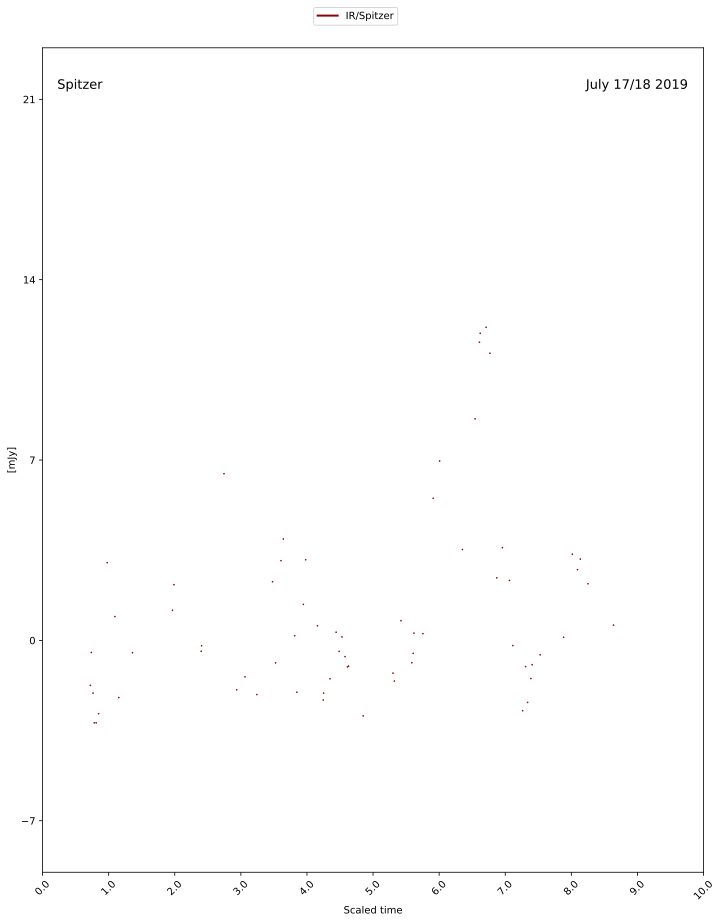

In [105]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(scaled_bmjd4[indices], flux_binned4[indices], s=0.5, color='darkred')
axs.set_ylim(-9, 23)
axs.set_yticks([-7, 0, 7, 14, 21])
axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

## GP

In [106]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   1.828479e+02   3.738833e+02 
    00s07  0013   1.463238e+02   1.356290e+01 
    00s10  0016   1.458318e+02   3.407306e-02 
    00s19  0022   1.457978e+02   3.582100e-13 
Runtime:     00s19
Optimization status: Converged



In [107]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test.reshape(-1, 1))

print(mean_squared_error(y_test, preds[0].flatten()))

3.114331772662845


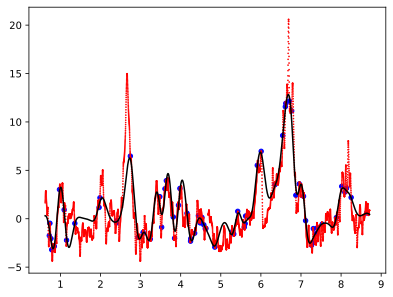

In [108]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

## MOPG

In [118]:
model = GPy.models.GPCoregionalizedRegression(X_list = [X1, X2, X3, X_train.reshape(-1, 1), X5], Y_list = [Y1, Y2, Y3, y_train.reshape(-1, 1), Y5], kernel=GPy.kern.RBF(1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0003   1.603585e+03   1.607867e+04 

 /home/gsasseville/.local/share/virtualenvs/MOPG-Nt0seseQ/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


    00s16  0004   1.456136e+03   4.730615e+03 
    04s30  0093   2.255300e+02   2.006960e-01 
    04s65  0098   2.255279e+02   6.270122e-08 
Runtime:     04s65
Optimization status: Converged



In [115]:
X_test_with_index = np.hstack((X_test.reshape(-1, 1), (3 * np.ones_like(X_test)).reshape(-1,1)))
Y_metadata = {'output_index': X_test_with_index[:, 1:].astype(int)}
preds = model.predict(X_test_with_index, Y_metadata=Y_metadata)

print(mean_squared_error(y_test, preds[0].flatten()))

12.459981891299494


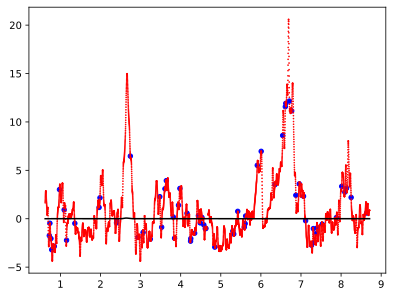

In [116]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

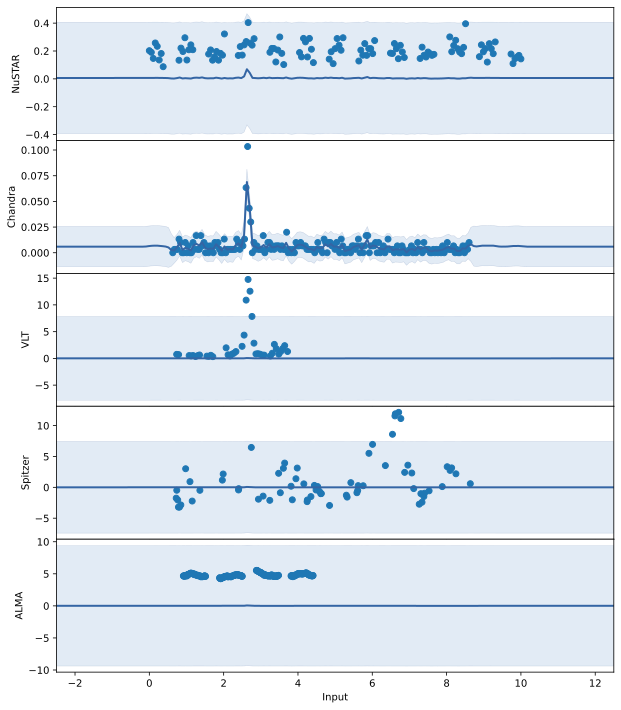

In [117]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)
X_list = [X1, X2, X3, X_train, X5]
Y_list = [Y1, Y2, Y3, y_train, Y5]
y_labels = ['NuSTAR', 'Chandra', 'VLT', 'Spitzer', 'ALMA']

# Loop through each output and plot in its respective subplot
for i in range(5):
    model.plot(plot_data = False, fignum=None, fixed_inputs=[(1, i)], ax=axs[i], legend=False)
    axs[i].scatter(X_list[i], Y_list[i])
    # axs[i].set_title()
    axs[i].set_ylabel(y_labels[i])
    if i == 4:
        axs[i].set_xlabel('Input')

# Interpolating first Spitzer peak - Comparison of GP vs MOPG

In [36]:
from scipy.signal import find_peaks, peak_prominences

peaks, _ = find_peaks(flux_binned4, height=0) 

# Calculate the prominence of each peak
prominences = peak_prominences(flux_binned4, peaks)[0]

# Find the index of the second most significant peak
sorted_indices = np.argsort(prominences)[::-1]
second_peak_idx = peaks[sorted_indices[1]]

# Determine the start and end of the second most significant peak
threshold = flux_binned4[second_peak_idx] * 0  # Example threshold at 50% peak height

# Find where the signal rises above and falls below the threshold
start_idx = np.where(flux_binned4[:second_peak_idx] < threshold)[0]
end_idx = np.where(flux_binned4[second_peak_idx:] < threshold)[0]

start_idx = start_idx[-1] if len(start_idx) > 0 else 0
end_idx = second_peak_idx + end_idx[0] if len(end_idx) > 0 else len(flux_binned4) - 1

# Print or use the start and end x-values
start_x = scaled_bmjd4[start_idx]
end_x = scaled_bmjd4[end_idx]

print(f"Second most significant peak starts at x = {start_x} and ends at x = {end_x}")


Second most significant peak starts at x = 2.5011323067633198 and ends at x = 2.8539101137429275


In [37]:
indices = np.arange(start_idx, end_idx + 1)
X_test = scaled_bmjd4[indices]
y_test = flux_binned4[indices]
X_train = np.delete(scaled_bmjd4, indices)
y_train = np.delete(flux_binned4, indices)

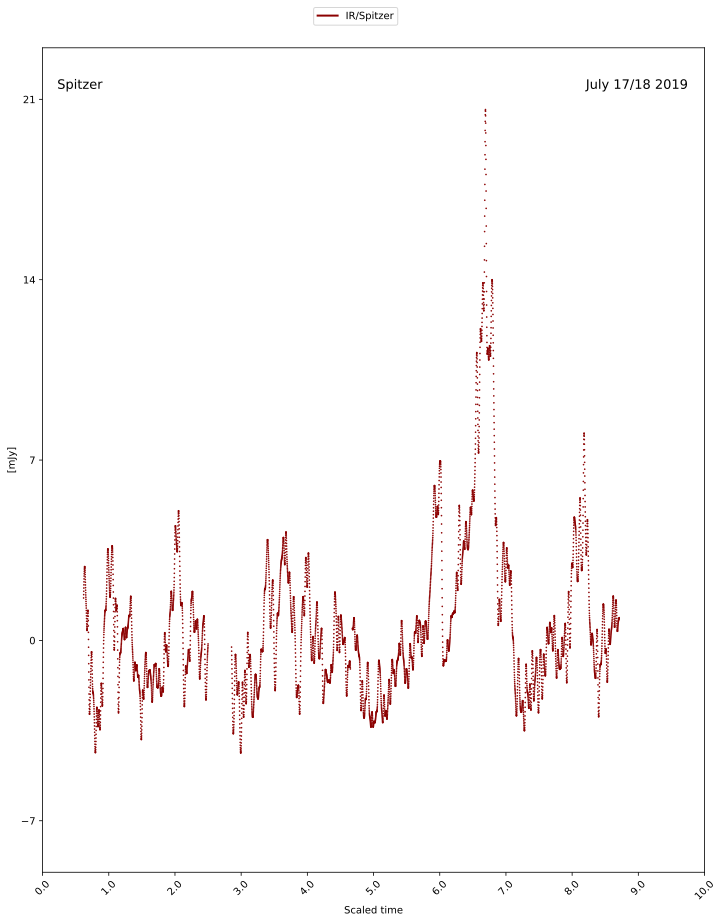

In [38]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(X_train, y_train, s=0.5, color='darkred')
axs.set_ylim(-9, 23)
axs.set_yticks([-7, 0, 7, 14, 21])
axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

In [39]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    42s18  0003   1.599940e+04   3.524360e+07 
Runtime:     42s18
Optimization status: None

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

# Interpolating ALMA continuous data - Comparison of GP vs MOPG

In [87]:
# Define the threshold for jumps
threshold = 0.25

# Calculate the difference between consecutive data points
diffs = np.diff(scaled_bmjd5)

# Find indices where the difference exceeds the threshold
jump_indices = np.where(np.abs(diffs) > threshold)[0]

# Since np.diff returns differences between consecutive elements,
# the indices correspond to the position between the elements.
# We can print the indices where the jumps occur
print("Indices where jumps greater than 0.25 occur:", jump_indices)

Indices where jumps greater than 0.25 occur: [ 48  97 146]


In [88]:
indices = np.arange(jump_indices[0] + 1, jump_indices[-1] + 1)
X_test = scaled_bmjd5[indices]
y_test = flux5[indices]
X_train = np.delete(scaled_bmjd5, indices)
y_train = np.delete(flux5, indices)

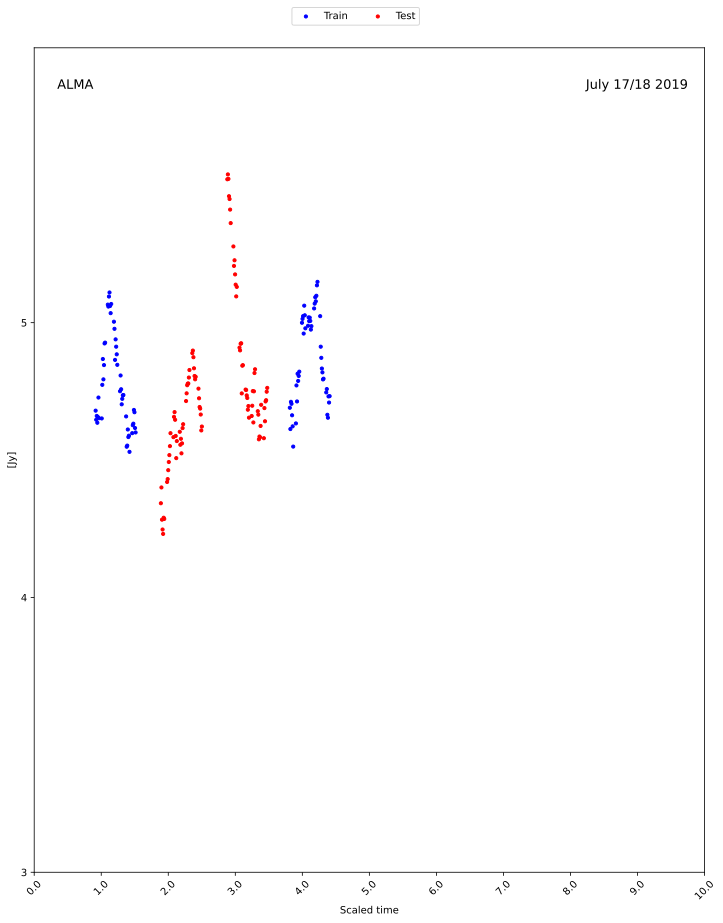

In [89]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(X_train, y_train, s=10, color='b', label='Train')
axs.scatter(X_test, y_test, s=10, color='r', label='Test')
axs.set_ylim(3, 6)
axs.set_yticks([3.0, 4.0, 5.0])
axs.set_ylabel('[Jy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'ALMA', fontsize=13)

# Add the legend with custom handles
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
# ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

## GP

In [90]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=GPy.kern.Bias(1) + GPy.kern.RBF(1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   7.136623e+01   1.287351e+03 


    00s10  0011  -1.216548e+02   1.773239e+02 
    00s16  0021  -1.420906e+02   4.222776e+00 
    00s19  0026  -1.422938e+02   3.410553e+00 
    00s27  0040  -1.429115e+02   9.328688e-08 
Runtime:     00s27
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x7bc383de6b30>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7bc383bd36a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7bc383bd3880>]}

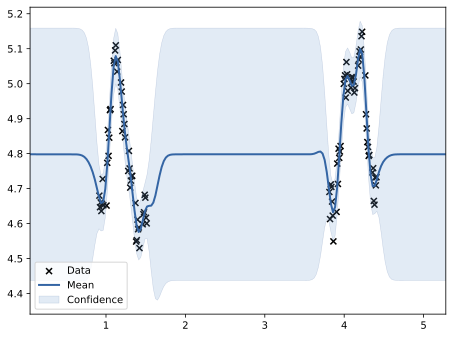

In [91]:
model.plot()

In [92]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test.reshape(-1, 1))

print(mean_squared_error(y_test, preds[0].flatten()))

0.08063556236677008


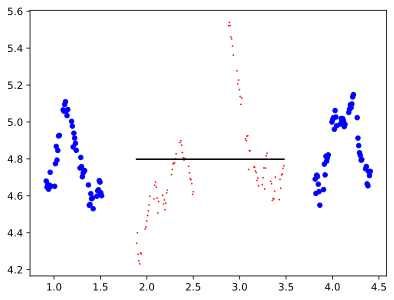

In [94]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

## MOPG

In [100]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.RBF(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=3,kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression(X_list = [X2, X3, X_train.reshape(-1, 1)], Y_list = [Y2, Y3, y_train.reshape(-1, 1)], kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
# m['.*linear.var'].constrain_fixed(1.)
m.optimize()
model

In [ ]:
model = GPy.models.GPCoregionalizedRegression(X_list = [X2, X3, X_train.reshape(-1, 1)], Y_list = [Y2, Y3, y_train.reshape(-1, 1)])
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0004   2.653099e+04   9.375226e+08 
    00s18  0007  -2.923587e+02   9.466686e+03 
    04s23  0188  -7.279142e+02   7.666883e+01 
    08s85  0336  -7.542162e+02   4.078198e-01 
Runtime:     08s85
Optimization status: Converged



In [101]:
X_test_with_index = np.hstack((X_test.reshape(-1, 1), (2 * np.ones_like(X_test)).reshape(-1,1)))
Y_metadata = {'output_index': X_test_with_index[:, 1:].astype(int)}
preds = model.predict(X_test_with_index, Y_metadata=Y_metadata)

print(mean_squared_error(y_test, preds[0].flatten()))

0.08063556236677008


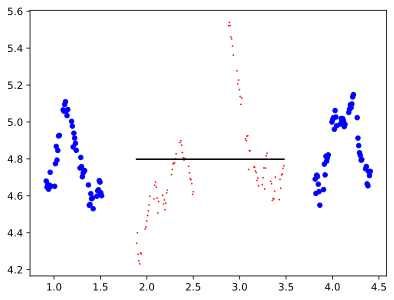

In [102]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

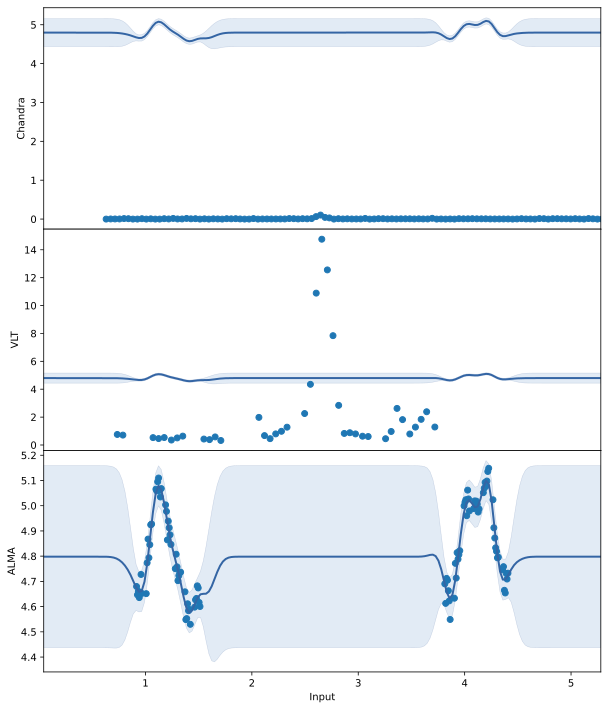

In [103]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)
X_list = [X2, X3, X_train.reshape(-1, 1)]
Y_list = [Y2, Y3, y_train.reshape(-1, 1)]
y_labels = ['Chandra', 'VLT', 'ALMA']

# Loop through each output and plot in its respective subplot
for i in range(3):
    model.plot(plot_data = False, fignum=None, ax=axs[i], legend=False)
    axs[i].scatter(X_list[i], Y_list[i])
    # axs[i].set_title()
    axs[i].set_ylabel(y_labels[i])
    if i == 2:
        axs[i].set_xlabel('Input')

# Interpolating VLT peak - Comparison of GP vs MOPG conditioned on Chandra only

In [ ]:
from scipy.signal import find_peaks, peak_prominences

peaks, _ = find_peaks(flux3, height=0) 

# Calculate the prominence of each peak
prominences = peak_prominences(flux3, peaks)[0]

# Find the index of the second most significant peak
sorted_indices = np.argsort(prominences)[::-1]
peak_idx = peaks[sorted_indices[0]]

# Determine the start and end of the second most significant peak
threshold = flux_binned4[peak_idx] * 0.3  # Example threshold at 50% peak height

# Find where the signal rises above and falls below the threshold
start_idx = np.where(flux3[:peak_idx] < threshold)[0]
end_idx = np.where(flux3[peak_idx:] < threshold)[0]

start_idx = start_idx[-1] if len(start_idx) > 0 else 0
end_idx = peak_idx + end_idx[0] if len(end_idx) > 0 else len(flux3) - 1

# Print or use the start and end x-values
start_x = scaled_bmjd3[start_idx]
end_x = scaled_bmjd3[end_idx]

print(f"Second most significant peak starts at x = {start_x} and ends at x = {end_x}")

Second most significant peak starts at x = 2.1714251366816355 and ends at x = 3.0401417714379275


In [ ]:
indices = np.arange(start_idx, end_idx + 1)
X_test = scaled_bmjd3[indices]
y_test = flux3[indices]
X_train = np.delete(scaled_bmjd3, indices)
y_train = np.delete(flux3, indices)

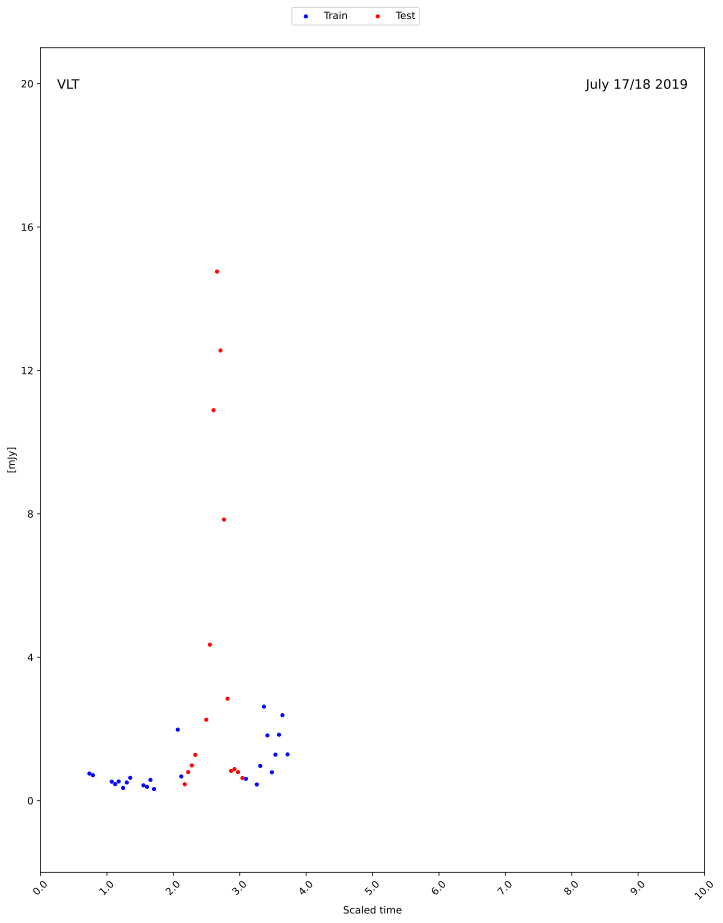

In [ ]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(X_train, y_train, s=10, color='b', label='Train')
axs.scatter(X_test, y_test, s=10, color='r', label='Test')
axs.set_ylim(-2, 21)
axs.set_yticks([0, 4, 8, 12, 16, 20])
axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'VLT', fontsize=13)

# Add the legend with custom handles
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
# ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

## GP

In [ ]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
model.rbf.lengthscale[:] = 0.25
model.rbf.lengthscale.fix()
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   2.620238e+01   2.938980e-01 

    00s01  0009   2.614013e+01   4.187416e-12 
    00s01  0010   2.614013e+01   4.187416e-12 
Runtime:     00s01
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x70111b0a9e40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x70111b534370>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x70111b534c10>]}

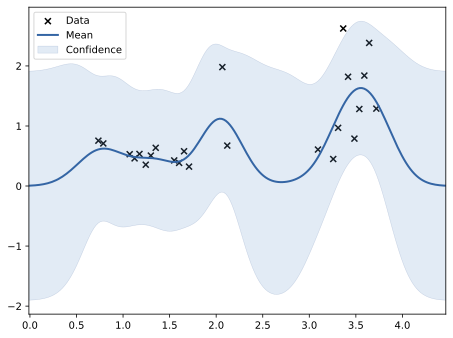

In [ ]:
model.plot()

In [ ]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test.reshape(-1, 1))

print(mean_squared_error(y_test, preds[0].flatten()))

38.721314103495686


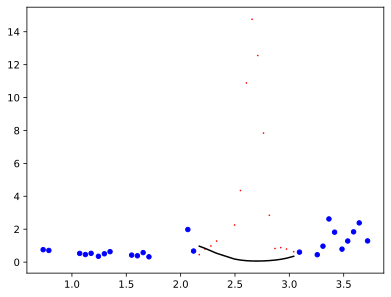

In [ ]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

## MOPG

In [ ]:
model = GPy.models.GPCoregionalizedRegression(X_list = [X2, X_train.reshape(-1, 1)], Y_list = [Y2, y_train.reshape(-1, 1)])
# model.optimize(messages=1)
model.coreg.rbf.lengthscale[:] = 0.25
model.coreg.rbf.lengthscale.fix()
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005  -1.554186e+02   7.221338e+03 
    00s19  0013  -4.710147e+02   1.720543e+03 
    01s05  0117  -5.986483e+02   1.520995e-04 
Runtime:     01s05
Optimization status: Converged



In [ ]:
X_test_with_index = np.hstack((X_test.reshape(-1, 1), (1 * np.ones_like(X_test)).reshape(-1,1)))
Y_metadata = {'output_index': X_test_with_index[:, 1:].astype(int)}
preds = model.predict(X_test_with_index, Y_metadata=Y_metadata)

print(mean_squared_error(y_test, preds[0].flatten()))

13.078076061793194


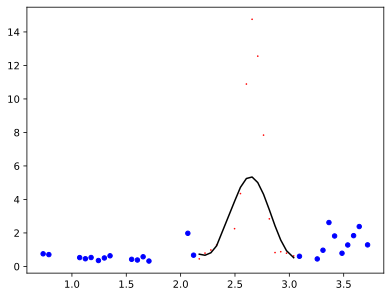

In [ ]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()